# Modelo Predictivo de Precios de Vivienda en Andalucía

Este cuaderno tiene como objetivo desarrollar un modelo predictivo para la estimación de precios de viviendas en Andalucía. Se utilizarán técnicas de preprocesamiento de datos, clustering para segmentación de mercado (opcionalmente como característica) y diversos algoritmas de regresión. El desarrollo se basará en los hallazgos de los análisis exploratorios previos.

**Pasos del Desarrollo:**
1.  Carga de Librerías y Datos.
2.  Ingeniería de Característica 'provincia'.
3.  Preprocesamiento de Datos (Numéricos y Categóricos).
4.  Implementación de Clustering para Segmentación de Mercado.
5.  División de Datos para Modelado Predictivo.
6.  Definición, Entrenamiento y Evaluación Inicial de Múltiples Modelos Predictivos.
7.  Optimización de Hiperparámetros del Mejor Modelo (o Modelos Prometedores).
8.  Validación Cruzada y Selección del Modelo Final.
9.  Evaluación Detallada del Modelo Final en el Conjunto de Prueba.
10. Análisis de Importancia de Características del Modelo Final.
11. Guardado del Modelo Final para Despliegue.

## 1. Carga de Librerías y Datos
En esta sección, importaremos las librerías necesarias para el análisis y la modelización, y cargaremos el dataset limpio de viviendas de Andalucía.

In [3]:
# Importaciones generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Modelos de regresión
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Para guardar el modelo
import joblib

# Para análisis de importancia de características (opcional, si se usa SHAP)
# import shap # Descomentar si se va a usar SHAP

# Configuraciones de visualización
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
# Definir rutas de archivos
# Ajusta esta ruta si la estructura de tu proyecto es diferente
# Asumimos que este notebook está en 'TFG---Predictor-Precios-Vivienda-Andalucia/notebooks/'
# y el CSV está en 'TFG---Predictor-Precios-Vivienda-Andalucia/data/clean/'
try:
    notebook_dir = os.getcwd() # Obtiene el directorio actual del notebook
    base_dir = os.path.dirname(notebook_dir) # Sube un nivel al directorio raíz del TFG
    data_dir = os.path.join(base_dir, 'data', 'clean')
    file_name = 'andalucia_clean_20250516.csv'
    file_path = os.path.join(data_dir, file_name)
    
    # Cargar el dataset
    df = pd.read_csv(file_path)
    print(f"Dataset cargado exitosamente desde: {file_path}")
    print(f"Dimensiones del dataset: {df.shape}")
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta esperada.")
    print(f"Ruta intentada: {file_path}")
    print(f"Asegúrate de que la ruta y el nombre del archivo son correctos y que el archivo existe.")
    print(f"Directorio base del proyecto asumido: {base_dir}")
    print(f"Directorio de datos asumido: {data_dir}")
    df = pd.DataFrame() # DataFrame vacío para evitar errores en celdas posteriores

# Inspección inicial de los datos
if not df.empty:
    print("\nPrimeras 5 filas del dataset:")
    display(df.head())
    print("\nInformación general del DataFrame:")
    df.info()
    print("\nEstadísticas descriptivas básicas:")
    display(df.describe())
    print("\nValores nulos por columna:")
    print(df.isnull().sum())
else:
    print("El DataFrame está vacío. No se pueden realizar más operaciones.")

Dataset cargado exitosamente desde: c:\Users\danie\Desktop\Universidad\TFG---Predictor-Precios-Vivienda-Andalucia\data\clean\andalucia_clean_20250516.csv
Dimensiones del dataset: (24107, 10)

Primeras 5 filas del dataset:


,precio,tipo_propiedad,superficie,habitaciones,baños,latitud,longitud,ubicacion,precio_m2,densidad_habitaciones
0,5800.00,casa_rural,168.00,4,1,37.12,-2.54,el almendral s/n,34.52,0.02
1,9000.00,chalet,60.00,2,1,37.35,-2.30,calle San Antonio,150.00,0.03
2,9500.00,chalet,115.00,3,1,37.35,-2.30,Olula del Río,82.61,0.03
3,9900.00,chalet,81.00,3,2,37.04,-2.74,"calle Lucero, 3",122.22,0.04
4,10000.00,piso,45.00,2,1,36.84,-2.48,calle Juan Goytisolo,222.22,0.04



Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24107 entries, 0 to 24106
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   precio                 24107 non-null  float64
 1   tipo_propiedad         24107 non-null  object 
 2   superficie             24107 non-null  float64
 3   habitaciones           24107 non-null  int64  
 4   baños                  24107 non-null  int64  
 5   latitud                24107 non-null  float64
 6   longitud               24107 non-null  float64
 7   ubicacion              24107 non-null  object 
 8   precio_m2              24107 non-null  float64
 9   densidad_habitaciones  24107 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.8+ MB

Estadísticas descriptivas básicas:


,precio,superficie,habitaciones,baños,latitud,longitud,precio_m2,densidad_habitaciones
count,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00
mean,672867.85,251.55,3.75,2.37,37.14,-5.01,1792.81,0.02
std,1593525.62,355.43,2.25,1.94,0.50,1.32,1826.00,0.01
min,3525.00,9.00,0.00,0.00,36.01,-7.49,11.09,0.00
25%,62100.00,87.00,3.00,1.00,36.76,-6.00,597.48,0.01
50%,100000.00,136.00,3.00,2.00,37.20,-5.02,1091.08,0.02
75%,550000.00,272.00,5.00,3.00,37.40,-4.14,2324.58,0.03
max,29000000.00,10000.00,70.00,35.00,38.60,-1.74,10000.00,0.15



Valores nulos por columna:
precio                   0
tipo_propiedad           0
superficie               0
habitaciones             0
baños                    0
latitud                  0
longitud                 0
ubicacion                0
precio_m2                0
densidad_habitaciones    0
dtype: int64


## 2. Ingeniería de Característica 'provincia' (Basado en análisis previo)
La característica 'provincia' es crucial ya que, como se observó en los análisis exploratorios (`analisis_visualizacion_por_provincia.ipynb` y `analisis_visualizacion v2.ipynb`), el mercado inmobiliario varía significativamente entre las distintas provincias de Andalucía. Esta variabilidad puede influir en los precios, tipos de propiedad predominantes, y otras dinámicas del mercado. Incluir 'provincia' como una característica puede ayudar al modelo a capturar estas diferencias regionales.

Implementaremos la lógica para extraer la provincia a partir de la columna 'ubicacion', manejando los casos donde la provincia no pueda ser determinada ('Desconocida').

In [5]:
if not df.empty:
    provincias_andalucia = ['Almería', 'Cádiz', 'Córdoba', 'Granada', 'Huelva', 'Jaén', 'Málaga', 'Sevilla']

    # Mapa extendido de términos a provincias (basado en analisis_visualizacion_por_provincia.ipynb)
    map_terminos_provincia = {
        # Almería
        'almería': 'Almería', 'almeria': 'Almería', 'roquetas de mar': 'Almería', 'el ejido': 'Almería', 
        'vera': 'Almería', 'níjar': 'Almería', 'adra': 'Almería', 'vícar': 'Almería', 
        'huercal-overa': 'Almería', 'huércal-overa': 'Almería', 'berja': 'Almería', 'albox': 'Almería', 
        'pulpí': 'Almería', 'cuevas del almanzora': 'Almería', 'mojacar': 'Almería', 'garrucha': 'Almería',
        'carboneras': 'Almería', 'la mojonera': 'Almería', 'olula del río': 'Almería', 'macael': 'Almería',
        'fines': 'Almería', 'cantoria': 'Almería', 'purchena': 'Almería', 'vélez-rubio': 'Almería',
        'vélez-blanco': 'Almería', 'tabernas': 'Almería', 'sorbas': 'Almería', 'gádor': 'Almería',
        'benahadux': 'Almería', 'huércal de almería': 'Almería', 'pechina': 'Almería', ' Viator': 'Almería',
        'tíjola': 'Almería', 'serón': 'Almería', 'lucainena de las torres': 'Almería', 'nacimiento': 'Almería',
        'abla': 'Almería', 'abrucena': 'Almería', 'fiñana': 'Almería', 'gergal': 'Almería', 'ulpiano': 'Almería',
        'las tres villas': 'Almería', 'escúllar': 'Almería', 'castro de filabres': 'Almería', 'velefique': 'Almería',
        'bacares': 'Almería', 'bayarque': 'Almería', 'armuña de almanzora': 'Almería', 'sufli': 'Almería',
        'sierro': 'Almería', 'laroya': 'Almería', 'lijár': 'Almería', 'cóbdar': 'Almería', 'chercos': 'Almería',
        'alcudia de monteagud': 'Almería', 'benitagla': 'Almería', 'benizalón': 'Almería', 'tahal': 'Almería',
        'senés': 'Almería', 'uleila del campo': 'Almería', 'lubrín': 'Almería', 'bédar': 'Almería',
        'los gallardos': 'Almería', 'turre': 'Almería', 'antás': 'Almería', 'zurgena': 'Almería',
        'arboleas': 'Almería', 'oria': 'Almería', 'partaloa': 'Almería', 'somontín': 'Almería', 'urraca': 'Almería',
        'chirivel': 'Almería', 'maría': 'Almería', 'topares': 'Almería', 'vélez blanco': 'Almería',
        'canjáyar': 'Almería', 'padules': 'Almería', 'almócita': 'Almería', 'beires': 'Almería',
        'fondón': 'Almería', 'laujar de andarax': 'Almería', 'paterna del río': 'Almería', 'bayárcal': 'Almería',
        'alsodux': 'Almería', 'santa cruz de marchena': 'Almería', 'terque': 'Almería', 'bentarique': 'Almería',
        'íllar': 'Almería', 'instinción': 'Almería', 'ráfol de almúnia': 'Almería', # Esto parece de Alicante, revisar
        'alhabia': 'Almería', 'alhama de almería': 'Almería', 'alicún': 'Almería', 'huécija': 'Almería',
        ' Enix': 'Almería', 'felix': 'Almería', 'dalías': 'Almería', 'balanegra': 'Almería',
        # Cádiz
        'cádiz': 'Cádiz', 'cadiz': 'Cádiz', 'jerez': 'Cádiz', 'jerez de la frontera': 'Cádiz', 
        'algeciras': 'Cádiz', 'san fernando': 'Cádiz', 'el puerto de santa maría': 'Cádiz', 
        'chiclana': 'Cádiz', 'chiclana de la frontera': 'Cádiz', 'sanlúcar de barrameda': 'Cádiz', 
        'la línea de la concepción': 'Cádiz', 'puerto real': 'Cádiz', 'arcos de la frontera': 'Cádiz', 
        'san roque': 'Cádiz', 'rota': 'Cádiz', 'los barrios': 'Cádiz', 'barbate': 'Cádiz', 
        'chipiona': 'Cádiz', 'tarifa': 'Cádiz', 'ubrique': 'Cádiz', 'conil de la frontera': 'Cádiz', 
        'villamartín': 'Cádiz', 'medina-sidonia': 'Cádiz', 'bornos': 'Cádiz', 'trebujena': 'Cádiz',
        'jimena de la frontera': 'Cádiz', 'vejer de la frontera': 'Cádiz', 'prado del rey': 'Cádiz',
        'algodonales': 'Cádiz', 'setenil de las bodegas': 'Cádiz', 'zahara de la sierra': 'Cádiz',
        'grazalema': 'Cádiz', 'olvera': 'Cádiz', 'alcalá de los gazules': 'Cádiz', 'paterna de rivera': 'Cádiz',
        'puerto serrano': 'Cádiz', 'espera': 'Cádiz', 'el bosque': 'Cádiz', 'castellar de la frontera': 'Cádiz',
        'san josé del valle': 'Cádiz', 'benalup-casas viejas': 'Cádiz', 'alcalá del valle': 'Cádiz',
        'el gastor': 'Cádiz', 'torre alháquime': 'Cádiz', 'benaocaz': 'Cádiz', 'villaluenga del rosario': 'Cádiz',
        # Córdoba
        'córdoba': 'Córdoba', 'cordoba': 'Córdoba', 'lucena': 'Córdoba', 'puente genil': 'Córdoba', 
        'montilla': 'Córdoba', 'priego de córdoba': 'Córdoba', 'palma del río': 'Córdoba', 
        'cabra': 'Córdoba', 'baena': 'Córdoba', 'pozoblanco': 'Córdoba', 'la carlota': 'Córdoba', 
        'aguilar de la frontera': 'Córdoba', 'montoro': 'Córdoba', 'peñarroya-pueblonuevo': 'Córdoba',
        'fernán-núñez': 'Córdoba', 'villafranca de córdoba': 'Córdoba', 'rute': 'Córdoba', 'iznájar': 'Córdoba',
        'castro del río': 'Córdoba', 'almodóvar del río': 'Córdoba', 'bujalance': 'Córdoba', 'hinojosa del duque': 'Córdoba',
        'nueva carteya': 'Córdoba', 'villa del río': 'Córdoba', 'posadas': 'Córdoba', 'santaella': 'Córdoba',
        'adamuz': 'Córdoba', 'el carpio': 'Córdoba', 'luque': 'Córdoba', 'espejo': 'Córdoba', 'montemayor': 'Córdoba',
        'hornachuelos': 'Córdoba', 'villanueva de córdoba': 'Córdoba', 'doña mencía': 'Córdoba', 'carcabuey': 'Córdoba',
        # Granada
        'granada': 'Granada', 'motril': 'Granada', 'almuñécar': 'Granada', 'armilla': 'Granada', 
        'maracena': 'Granada', 'baza': 'Granada', 'loja': 'Granada', 'las gabias': 'Granada', 
        'guadix': 'Granada', 'la zubia': 'Granada', 'albolote': 'Granada', 'atarfe': 'Granada', 
        'santa fe': 'Granada', 'ogíjares': 'Granada', 'salobreña': 'Granada', 'huétor vega': 'Granada',
        'peligros': 'Granada', 'pinos puente': 'Granada', 'huétor tájar': 'Granada', 'illora': 'Granada',
        'churriana de la vega': 'Granada', 'cenes de la vega': 'Granada', 'monachil': 'Granada', 'durcal': 'Granada',
        'montefrío': 'Granada', 'alhama de granada': 'Granada', 'padul': 'Granada', 'vélez de benaudalla': 'Granada',
        'cúllar vega': 'Granada', 'gójar': 'Granada', 'güejar sierra': 'Granada', 'lanjarón': 'Granada',
        # Huelva
        'huelva': 'Huelva', 'lepe': 'Huelva', 'almonte': 'Huelva', 'isla cristina': 'Huelva', 
        'ayamonte': 'Huelva', 'moguer': 'Huelva', 'cartaya': 'Huelva', 'punta umbría': 'Huelva', 
        'aljaraque': 'Huelva', 'valverde del camino': 'Huelva', 'gibraleón': 'Huelva', 
        'palos de la frontera': 'Huelva', 'la palma del condado': 'Huelva', 'bollullos par del condado': 'Huelva',
        'aracena': 'Huelva', 'rociana del condado': 'Huelva', 'trigueros': 'Huelva', 'bonaress': 'Huelva',
        'san juan del puerto': 'Huelva', 'cortegana': 'Huelva', 'calañas': 'Huelva', 'zalamea la real': 'Huelva',
        'niebla': 'Huelva', 'beas': 'Huelva', 'minas de riotinto': 'Huelva', 'jabugo': 'Huelva',
        # Jaén
        'jaén': 'Jaén', 'jaen': 'Jaén', 'linares': 'Jaén', 'ándujar': 'Jaén', 'úbeda': 'Jaén', 
        'martos': 'Jaén', 'alcalá la real': 'Jaén', 'bailén': 'Jaén', 'baeza': 'Jaén', 
        'la carolina': 'Jaén', 'torredonjimeno': 'Jaén', 'torredelcampo': 'Jaén', 'jódar': 'Jaén', 
        'mancha real': 'Jaén', 'villacarrillo': 'Jaén', 'alcaudete': 'Jaén', 'mengíbar': 'Jaén',
        'cazorla': 'Jaén', 'navas de san juan': 'Jaén', 'castillo de locubín': 'Jaén', 'vilches': 'Jaén',
        'huelma': 'Jaén', 'quesada': 'Jaén', 'sabiote': 'Jaén', 'begíjar': 'Jaén', 'rus': 'Jaén',
        # Málaga
        'málaga': 'Málaga', 'malaga': 'Málaga', 'marbella': 'Málaga', 'fuengirola': 'Málaga', 
        'vélez-málaga': 'Málaga', 'torremolinos': 'Málaga', 'benalmádena': 'Málaga', 'estepona': 'Málaga', 
        'mijas': 'Málaga', 'rincón de la victoria': 'Málaga', 'antequera': 'Málaga', 'ronda': 'Málaga', 
        'alhaurín de la torre': 'Málaga', 'alhaurín el grande': 'Málaga', 'nerja': 'Málaga', 
        'torrox': 'Málaga', 'manilva': 'Málaga', 'coín': 'Málaga', 'cártama': 'Málaga', 'estepona': 'Málaga',
        'benahavís': 'Málaga', 'casares': 'Málaga', 'ojén': 'Málaga', 'istá': 'Málaga', 'archidona': 'Málaga',
        'campillos': 'Málaga', 'pizarra': 'Málaga', 'alameda': 'Málaga', 'mollina': 'Málaga', 'colmenar': 'Málaga',
        'riogordo': 'Málaga', 'alcaucín': 'Málaga', 'frigiliana': 'Málaga', 'competa': 'Málaga', 'sayalonga': 'Málaga',
        # Sevilla
        'sevilla': 'Sevilla', 'dos hermanas': 'Sevilla', 'alcalá de guadaíra': 'Sevilla', 'alcala de guadaira': 'Sevilla', 
        'utrera': 'Sevilla', 'mairena del aljarafe': 'Sevilla', 'écija': 'Sevilla', 'ecija': 'Sevilla', 
        'la rinconada': 'Sevilla', 'los palacios y villafranca': 'Sevilla', 'coria del río': 'Sevilla', 
        'carmona': 'Sevilla', 'morón de la frontera': 'Sevilla', 'lebrija': 'Sevilla', 'camas': 'Sevilla', 
        'tomares': 'Sevilla', 'mairena del alcor': 'Sevilla', 'san juan de aznalfarache': 'Sevilla', 
        'bormujos': 'Sevilla', 'marchena': 'Sevilla', 'arahal': 'Sevilla', 'el viso del alcor': 'Sevilla', 
        'osuna': 'Sevilla', 'castilleja de la cuesta': 'Sevilla', 'las cabezas de san juan': 'Sevilla', 
        'pilas': 'Sevilla', 'espartinas': 'Sevilla', 'gines': 'Sevilla', 'sanlúcar la mayor': 'Sevilla',
        'brenes': 'Sevilla', 'estepa': 'Sevilla', 'gelves': 'Sevilla', 'la algaba': 'Sevilla', 'Lora del Río': 'Sevilla'
    }

    def extraer_provincia(ubicacion_str):
        if not isinstance(ubicacion_str, str):
            return 'Desconocida'
        
        ubicacion_lower = ubicacion_str.lower()
        
        # Primero, buscar nombres directos de provincia
        for prov_keyword in provincias_andalucia:
            if prov_keyword.lower() in ubicacion_lower:
                # Asegurar que no es parte de una palabra más larga, e.g. "Almería" vs "Palmería"
                # Podríamos usar regex \bprov_keyword.lower()\b
                # Por simplicidad, si el nombre de la provincia está, lo tomamos.
                # Esto puede mejorarse con lógica más robusta si hay ambigüedades.
                return prov_keyword
        
        # Luego, buscar términos específicos (ciudades, etc.)
        # Ordenar por longitud de término para que "jerez de la frontera" se detecte antes que "jerez"
        sorted_terminos = sorted(map_terminos_provincia.keys(), key=len, reverse=True)

        for termino in sorted_terminos:
            if termino in ubicacion_lower:
                return map_terminos_provincia[termino]
        
        return 'Desconocida'

    if 'ubicacion' in df.columns:
        df['provincia'] = df['ubicacion'].apply(extraer_provincia)
        print("\nConteo de propiedades por provincia extraída (incluyendo 'Desconocida'):")
        print(df['provincia'].value_counts())
        
        num_desconocidas = df[df['provincia'] == 'Desconocida'].shape[0]
        total_props = len(df)
        if num_desconocidas > 0:
            porc_desconocidas = (num_desconocidas / total_props) * 100
            print(f"\nAdvertencia: {num_desconocidas} de {total_props} propiedades ({porc_desconocidas:.2f}%) no pudieron ser asignadas a una provincia.")
            # print("Ejemplos de 'ubicacion' no mapeadas:")
            # display(df[df['provincia'] == 'Desconocida']['ubicacion'].value_counts().head(10))
    else:
        print("La columna 'ubicacion' no existe, no se puede extraer la provincia.")
        df['provincia'] = 'No disponible' # Columna placeholder

    # Verificar si la columna 'provincia' se añadió correctamente
    if 'provincia' in df.columns:
        print("\nPrimeras filas con la nueva columna 'provincia':")
        display(df[['ubicacion', 'provincia', 'precio']].head())
else:
    print("El DataFrame está vacío. No se puede realizar la ingeniería de características.")


Conteo de propiedades por provincia extraída (incluyendo 'Desconocida'):
provincia
Desconocida    20366
Almería          716
Cádiz            581
Málaga           549
Córdoba          517
Huelva           489
Sevilla          460
Granada          338
Jaén              91
Name: count, dtype: int64

Advertencia: 20366 de 24107 propiedades (84.48%) no pudieron ser asignadas a una provincia.

Primeras filas con la nueva columna 'provincia':


,ubicacion,provincia,precio
0,el almendral s/n,Desconocida,5800.00
1,calle San Antonio,Desconocida,9000.00
2,Olula del Río,Almería,9500.00
3,"calle Lucero, 3",Desconocida,9900.00
4,calle Juan Goytisolo,Desconocida,10000.00


## 3. Preprocesamiento de Datos (Numéricos y Categóricos)
Antes de entrenar los modelos, es necesario preprocesar los datos. Esto incluye:
-   **Imputación de valores faltantes:** Usaremos la mediana para características numéricas y la moda para categóricas.
-   **Escalado de características numéricas:** Aplicaremos `StandardScaler` para normalizar las características numéricas.
-   **Codificación de características categóricas:** Usaremos `OneHotEncoder` para convertir las variables categóricas en un formato numérico que los modelos puedan entender.

Se creará un `ColumnTransformer` para aplicar estos pasos de manera organizada.

In [6]:
if not df.empty:
    # Eliminar filas donde el precio (variable objetivo) es NaN, si existen
    df.dropna(subset=['precio'], inplace=True)
    print(f"Dimensiones del dataset después de eliminar filas con 'precio' NaN: {df.shape}")

    # Identificar características numéricas y categóricas
    # Excluimos 'latitud', 'longitud', 'ubicacion' del preprocesamiento directo para el modelo,
    # a menos que se decida usarlas de forma específica (e.g., para clustering o características geoespaciales).
    # 'precio_m2' y 'densidad_habitaciones' son derivadas de 'precio' y 'superficie'/'habitaciones',
    # podrían causar multicolinealidad o data leakage si se usan directamente para predecir 'precio'.
    # Por ahora, las excluimos de X.
    
    # Seleccionar características para el modelo
    # 'tipo_propiedad', 'superficie', 'habitaciones', 'baños', 'provincia'
    # 'precio' es el objetivo (y)
    
    numeric_features = ['superficie', 'habitaciones', 'baños'] 
    # Asegurarse de que estas columnas existen y son numéricas
    for col in numeric_features:
        if col not in df.columns:
            print(f"Advertencia: La columna numérica '{col}' no se encuentra en el DataFrame. Será omitida.")
            numeric_features.remove(col)
        elif not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Advertencia: La columna '{col}' no es numérica. Intentando convertir o será omitida.")
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce') # Convertir a numérico, NaNs si no es posible
                if df[col].isnull().all(): # Si toda la columna es NaN después de la conversión
                    print(f"La columna '{col}' es completamente NaN después de la conversión. Será omitida.")
                    numeric_features.remove(col)
            except:
                print(f"No se pudo convertir '{col}' a numérico. Será omitida.")
                numeric_features.remove(col)


    categorical_features = ['tipo_propiedad', 'provincia']
    for col in categorical_features:
        if col not in df.columns:
            print(f"Advertencia: La columna categórica '{col}' no se encuentra en el DataFrame. Será omitida.")
            categorical_features.remove(col)
        elif df[col].nunique() < 2 and col != 'provincia': # Permitir 'provincia' si solo hay una (aunque raro)
             print(f"Advertencia: La columna categórica '{col}' tiene menos de 2 valores únicos. Podría ser problemática para OneHotEncoding. Se mantendrá por ahora.")


    # Definir transformadores
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # o 'constant', fill_value='missing'
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False para que sea denso
    ])

    # Crear ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ], 
        remainder='drop' # 'passthrough' si quieres mantener otras columnas no especificadas
    )
    
    # Preparar X e y
    # Asegurarse de que las columnas seleccionadas para X existen
    features_for_X = numeric_features + categorical_features
    missing_cols_in_df = [col for col in features_for_X if col not in df.columns]
    
    if missing_cols_in_df:
        print(f"Error: Las siguientes columnas necesarias para X no están en el DataFrame: {missing_cols_in_df}")
        # Podrías detener la ejecución o manejarlo de otra forma
        X = pd.DataFrame() # DataFrame vacío
        y = pd.Series(dtype='float64') # Serie vacía
    elif 'precio' not in df.columns:
        print("Error: La columna 'precio' (variable objetivo) no se encuentra en el DataFrame.")
        X = pd.DataFrame() 
        y = pd.Series(dtype='float64')
    else:
        X = df[features_for_X]
        y = df['precio']
        print(f"\nCaracterísticas seleccionadas para X (antes del preprocesamiento): {X.columns.tolist()}")
        print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")

        # Aplicar el preprocesador para ver la forma de X_processed (opcional aquí, se hará en el pipeline)
        # X_processed_temp = preprocessor.fit_transform(X)
        # print(f"Forma de X después del preprocesamiento (ejemplo): {X_processed_temp.shape}")
        # feature_names_out = preprocessor.get_feature_names_out()
        # print(f"Nombres de características después del preprocesamiento: {feature_names_out[:10]}...") # Mostrar algunos
else:
    print("El DataFrame está vacío. No se puede realizar el preprocesamiento.")
    # Definir X e y como vacíos para evitar errores en celdas posteriores si se ejecutan
    X = pd.DataFrame()
    y = pd.Series(dtype='float64')
    preprocessor = None

Dimensiones del dataset después de eliminar filas con 'precio' NaN: (24107, 11)

Características seleccionadas para X (antes del preprocesamiento): ['superficie', 'habitaciones', 'baños', 'tipo_propiedad', 'provincia']
Forma de X: (24107, 5), Forma de y: (24107,)


## 4. Implementación de Clustering para Segmentación de Mercado
Se puede aplicar clustering (como K-Means) sobre características relevantes (e.g., `superficie`, `precio_m2`, `latitud`, `longitud`, `tipo_propiedad` después de codificar) para identificar segmentos naturales en el mercado inmobiliario. La pertenencia a un cluster podría luego usarse como una nueva característica en los modelos de regresión.

**Nota:** Para este paso, necesitaríamos datos preprocesados. Si usamos `latitud` y `longitud`, deben ser escaladas. `precio_m2` también podría ser útil aquí.

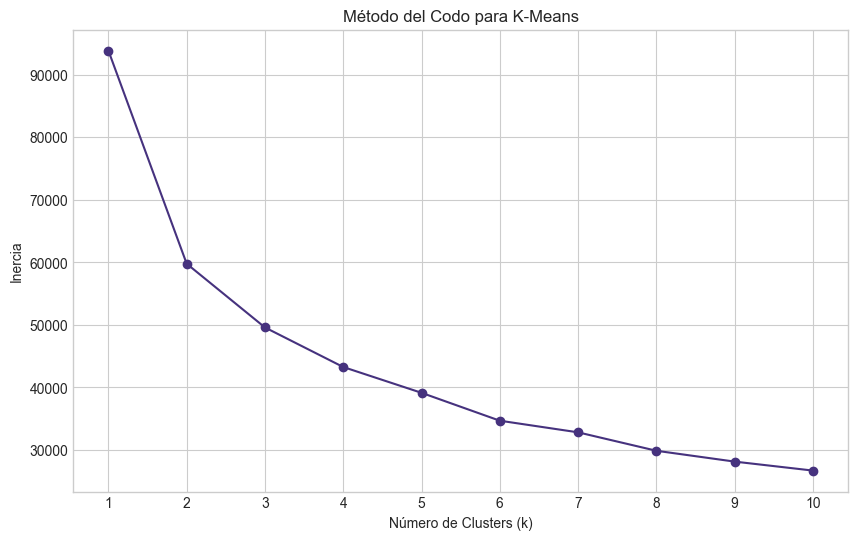

Número óptimo de clusters seleccionado (ejemplo): 4

Conteo de propiedades por cluster:
cluster
3    10002
1     8273
0     4912
2      920
Name: count, dtype: int64

Media de precio y superficie por cluster:


,precio,superficie
cluster,,
0,1640979.86,479.05
1,155365.63,97.13
2,5159554.12,1415.86
3,212777.69,160.45


In [7]:
if not X.empty and preprocessor is not None:
    # Seleccionar características para clustering. Podrían ser diferentes de las del modelo de regresión.
    # Por ejemplo, podríamos incluir latitud y longitud aquí si están disponibles y son relevantes.
    # También podríamos usar 'precio_m2' para segmentar.
    
    # Ejemplo: Usar superficie, habitaciones, baños (ya preprocesadas) y provincia (ya preprocesada)
    # Para usar latitud/longitud, necesitarían su propio preprocesamiento (imputación, escalado)
    # y ser añadidas al preprocessor o preprocesadas por separado.
    
    # Vamos a aplicar el preprocesador a X para obtener los datos transformados
    try:
        X_processed_for_clustering = preprocessor.fit_transform(X)
        
        # Determinar el número óptimo de clusters (e.g., método del codo)
        inertia = []
        k_range = range(1, 11) # Probar de 1 a 10 clusters
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(X_processed_for_clustering)
            inertia.append(kmeans.inertia_)
        
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertia, marker='o')
        plt.title('Método del Codo para K-Means')
        plt.xlabel('Número de Clusters (k)')
        plt.ylabel('Inercia')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        
        # Basado en el gráfico del codo, elegir un k_optimo.
        # Por ejemplo, si el codo está en k=3 o k=4:
        k_optimo = 4 # Este valor debe ajustarse según el gráfico
        print(f"Número óptimo de clusters seleccionado (ejemplo): {k_optimo}")

        # Aplicar K-Means con el k óptimo
        kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init='auto')
        df['cluster'] = kmeans_final.fit_predict(X_processed_for_clustering)
        
        print("\nConteo de propiedades por cluster:")
        print(df['cluster'].value_counts())
        
        # Analizar características de los clusters (ejemplo con 'precio' y 'superficie')
        if 'precio' in df.columns and 'superficie' in df.columns:
            print("\nMedia de precio y superficie por cluster:")
            display(df.groupby('cluster')[['precio', 'superficie']].mean())

        # Visualizar los clusters (ejemplo con 2D, si es posible reducir dimensionalidad o usar 2 features)
        # Esto es más complejo con datos de alta dimensionalidad post-OneHotEncoding.
        # Podríamos usar PCA para reducir a 2D para visualización.
        # O visualizar sobre las características originales más importantes.
        
        # Ejemplo de visualización (requiere que X_processed_for_clustering tenga al menos 2D)
        # Si se usó PCA:
        # from sklearn.decomposition import PCA
        # pca = PCA(n_components=2)
        # X_pca = pca.fit_transform(X_processed_for_clustering)
        # plt.figure(figsize=(10, 7))
        # sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis', legend='full')
        # plt.title(f'Clusters K-Means (k={k_optimo}) visualizados con PCA')
        # plt.xlabel('Componente Principal 1')
        # plt.ylabel('Componente Principal 2')
        # plt.show()

        # Ahora 'cluster' es una nueva característica en df.
        # Podríamos añadirla a X antes de dividir en train/test para los modelos de regresión.
        # X['cluster'] = df['cluster'] # Esto modificaría X, hay que tener cuidado con el orden de operaciones.
        # O, mejor, rehacer el preprocesador para incluir 'cluster' si se decide usarla.
        # Por ahora, la dejamos en df y decidiremos más tarde si incluirla.

    except Exception as e:
        print(f"Error durante el clustering: {e}")
        if 'cluster' not in df.columns: # Asegurar que la columna no se añade si hay error
             df['cluster'] = np.nan 
else:
    print("X está vacío o el preprocesador no está definido. No se puede realizar clustering.")
    if 'df' in globals() and isinstance(df, pd.DataFrame):
        df['cluster'] = np.nan # Añadir columna vacía para evitar errores si se referencia después

## 5. División de Datos para Modelado Predictivo
Dividiremos el conjunto de datos `X` (características preprocesadas) e `y` (variable objetivo) en conjuntos de entrenamiento y prueba. Esto nos permitirá entrenar los modelos con una porción de los datos y evaluarlos con datos que no han visto antes, para obtener una estimación imparcial de su rendimiento.

In [8]:
if not X.empty and not y.empty:
    # Si decidimos usar 'cluster' como característica, la añadimos a X ANTES de dividir.
    # Por simplicidad, y para no rehacer el preprocesador ahora, no la incluiremos en X para los modelos de regresión en este paso.
    # Si se quisiera incluir, se debería:
    # 1. Asegurar que 'cluster' está en `df` y es numérica.
    # 2. Añadir 'cluster' a `numeric_features` o tratarla por separado si no necesita escalado.
    # 3. Rehacer X = df[features_for_X_con_cluster]
    # 4. El preprocesador debería ajustarse para manejar 'cluster' (e.g., como 'passthrough' o parte de 'num').

    # Dividir los datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Forma de X_train: {X_train.shape}")
    print(f"Forma de X_test: {X_test.shape}")
    print(f"Forma de y_train: {y_train.shape}")
    print(f"Forma de y_test: {y_test.shape}")
else:
    print("X o y están vacíos. No se puede dividir el dataset.")
    # Definir variables vacías para evitar errores en celdas posteriores
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')

Forma de X_train: (19285, 5)
Forma de X_test: (4822, 5)
Forma de y_train: (19285,)
Forma de y_test: (4822,)


## 6. Definición, Entrenamiento y Evaluación Inicial de Múltiples Modelos Predictivos
Definiremos una variedad de modelos de regresión. Cada modelo se entrenará utilizando un pipeline que incluye el preprocesador definido anteriormente. Evaluaremos su rendimiento inicial en el conjunto de prueba utilizando métricas como el Error Cuadrático Medio (MSE), Error Absoluto Medio (MAE) y el Coeficiente de Determinación (R²).

In [9]:
if not X_train.empty and preprocessor is not None:
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(random_state=42),
        'Ridge': Ridge(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(),
        'K-Neighbors Regressor': KNeighborsRegressor(n_jobs=-1)
        # 'MLP Regressor': MLPRegressor(random_state=42, max_iter=500, early_stopping=True) # MLP puede ser lento
    }

    results = []

    for name, model in models.items():
        print(f"Entrenando y evaluando: {name}")
        # Crear el pipeline completo: preprocesador + modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model)])
        
        try:
            # Entrenar el pipeline
            pipeline.fit(X_train, y_train)
            
            # Realizar predicciones en el conjunto de prueba
            y_pred = pipeline.predict(X_test)
            
            # Calcular métricas
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            results.append({
                'Model': name,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            print(f"{name} - R2: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}\n")
            
        except Exception as e:
            print(f"Error entrenando o evaluando {name}: {e}\n")
            results.append({
                'Model': name,
                'MSE': np.nan,
                'RMSE': np.nan,
                'MAE': np.nan,
                'R2': np.nan
            })

    # Mostrar resultados en una tabla
    results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
    print("\n--- Resultados de la Evaluación Inicial de Modelos ---")
    display(results_df)
else:
    print("X_train está vacío o el preprocesador no está definido. No se pueden entrenar modelos.")
    results_df = pd.DataFrame()

Entrenando y evaluando: Linear Regression
Linear Regression - R2: 0.5843, MAE: 521854.46, RMSE: 1041033.31

Entrenando y evaluando: Lasso


c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+15, tolerance: 4.864e+12
  model = cd_fast.enet_coordinate_descent(


Lasso - R2: 0.5843, MAE: 521851.17, RMSE: 1041033.55

Entrenando y evaluando: Ridge
Ridge - R2: 0.5843, MAE: 521796.94, RMSE: 1041036.60

Entrenando y evaluando: Decision Tree
Decision Tree - R2: 0.6952, MAE: 267755.02, RMSE: 891420.97

Entrenando y evaluando: Random Forest
Random Forest - R2: 0.7543, MAE: 250624.65, RMSE: 800393.69

Entrenando y evaluando: Gradient Boosting
Gradient Boosting - R2: 0.7275, MAE: 308545.74, RMSE: 842861.75

Entrenando y evaluando: SVR
SVR - R2: -0.1301, MAE: 623036.40, RMSE: 1716431.05

Entrenando y evaluando: K-Neighbors Regressor
K-Neighbors Regressor - R2: 0.7307, MAE: 277824.46, RMSE: 837842.30


--- Resultados de la Evaluación Inicial de Modelos ---


,Model,MSE,RMSE,MAE,R2
4,Random Forest,640630056636.41,800393.69,250624.65,0.75
7,K-Neighbors Regressor,701979714091.66,837842.30,277824.46,0.73
5,Gradient Boosting,710415924430.63,842861.75,308545.74,0.73
3,Decision Tree,794631351611.78,891420.97,267755.02,0.70
0,Linear Regression,1083750351309.77,1041033.31,521854.46,0.58
1,Lasso,1083750842737.91,1041033.55,521851.17,0.58
2,Ridge,1083757201359.34,1041036.60,521796.94,0.58
6,SVR,2946135547095.98,1716431.05,623036.40,-0.13


## 7. Optimización de Hiperparámetros del Mejor Modelo (o Modelos Prometedores)
Seleccionaremos uno o dos de los modelos con mejor rendimiento inicial (basado en R² y MAE/RMSE) y utilizaremos `GridSearchCV` o `RandomizedSearchCV` para encontrar la combinación óptima de hiperparámetros. Esto se hará sobre el conjunto de entrenamiento para evitar el sobreajuste al conjunto de prueba.

In [10]:
if not results_df.empty and not X_train.empty and preprocessor is not None:
    # Seleccionar el mejor modelo (o modelos) basado en R2, por ejemplo
    # Tomaremos el mejor modelo de results_df
    if not results_df.dropna(subset=['R2']).empty:
        best_model_name_initial = results_df.dropna(subset=['R2']).iloc[0]['Model']
        print(f"Modelo seleccionado para optimización (basado en R2 inicial): {best_model_name_initial}")

        # Definir el modelo base y el espacio de parámetros para GridSearchCV
        # Ejemplo con RandomForestRegressor
        if best_model_name_initial == 'Random Forest':
            model_to_optimize = RandomForestRegressor(random_state=42, n_jobs=-1)
            param_grid_rf = {
                'regressor__n_estimators': [100, 200, 300], # Número de árboles
                'regressor__max_depth': [None, 10, 20, 30],    # Profundidad máxima
                'regressor__min_samples_split': [2, 5, 10], # Mínimo de muestras para dividir un nodo
                'regressor__min_samples_leaf': [1, 2, 4]    # Mínimo de muestras en un nodo hoja
            }
            # Usar RandomizedSearchCV para una búsqueda más eficiente si el espacio es grande
            search_method = RandomizedSearchCV(
                Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model_to_optimize)]),
                param_distributions=param_grid_rf,
                n_iter=10, # Número de combinaciones a probar (ajustar según tiempo disponible)
                cv=3,      # Número de folds para validación cruzada (ajustar)
                scoring='r2',
                random_state=42,
                n_jobs=-1, # Usar todos los procesadores disponibles
                verbose=1
            )
            param_grid = param_grid_rf # Para referencia

        elif best_model_name_initial == 'Gradient Boosting':
            model_to_optimize = GradientBoostingRegressor(random_state=42)
            param_grid_gb = {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__learning_rate': [0.01, 0.05, 0.1],
                'regressor__max_depth': [3, 5, 7],
                'regressor__subsample': [0.7, 0.8, 0.9]
            }
            search_method = RandomizedSearchCV(
                Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model_to_optimize)]),
                param_distributions=param_grid_gb,
                n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1, verbose=1
            )
            param_grid = param_grid_gb # Para referencia
            
        # Añadir más 'elif' para otros modelos si es necesario, o crear una estructura más genérica.
        else:
            print(f"Optimización no implementada para {best_model_name_initial}. Se usará el modelo con parámetros por defecto.")
            # En este caso, podríamos simplemente re-entrenar el mejor modelo sin optimización
            # o seleccionar un modelo para el cual sí tengamos un grid de parámetros.
            # Por ahora, si no es RF o GB, no optimizamos.
            best_model_pipeline_optimized = Pipeline(steps=[('preprocessor', preprocessor), 
                                                            ('regressor', models[best_model_name_initial])])
            best_model_pipeline_optimized.fit(X_train, y_train) # Entrenar con datos de entrenamiento
            print(f"Modelo {best_model_name_initial} entrenado con parámetros por defecto.")
            search_method = None # Para indicar que no hubo búsqueda

        if search_method:
            print(f"\nIniciando optimización de hiperparámetros para {best_model_name_initial}...")
            try:
                search_method.fit(X_train, y_train)
                
                print(f"\nMejores parámetros encontrados para {best_model_name_initial}:")
                print(search_method.best_params_)
                
                print(f"\nMejor R2 (CV) para {best_model_name_initial}: {search_method.best_score_:.4f}")
                
                # El mejor pipeline ya está entrenado con los mejores parámetros y todos los datos de X_train
                best_model_pipeline_optimized = search_method.best_estimator_
                
            except Exception as e:
                print(f"Error durante la optimización de {best_model_name_initial}: {e}")
                # Fallback: usar el modelo con parámetros por defecto
                best_model_pipeline_optimized = Pipeline(steps=[('preprocessor', preprocessor), 
                                                                ('regressor', models[best_model_name_initial])])
                best_model_pipeline_optimized.fit(X_train, y_train)
                print(f"Fallback: Modelo {best_model_name_initial} entrenado con parámetros por defecto debido a error en optimización.")
        
    else:
        print("No hay resultados de modelos iniciales para seleccionar el mejor y optimizar.")
        best_model_pipeline_optimized = None
else:
    print("No hay resultados de modelos, X_train está vacío o el preprocesador no está definido. No se puede optimizar.")
    best_model_pipeline_optimized = None

Modelo seleccionado para optimización (basado en R2 inicial): Random Forest

Iniciando optimización de hiperparámetros para Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Mejores parámetros encontrados para Random Forest:
{'regressor__n_estimators': 300, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}

Mejor R2 (CV) para Random Forest: 0.7836


## 8. Validación Cruzada y Selección del Modelo Final
Aplicaremos validación cruzada (k-fold) sobre el conjunto de entrenamiento con el modelo (o modelos) optimizado para obtener una estimación más robusta de su rendimiento. Esto ayuda a asegurar que el rendimiento del modelo no es una casualidad debido a una particular división de entrenamiento/prueba.

In [11]:
if best_model_pipeline_optimized is not None and not X_train.empty:
    # El pipeline 'best_model_pipeline_optimized' ya contiene el preprocesador y el regresor con los mejores hiperparámetros.
    # Si RandomizedSearchCV/GridSearchCV se usó con cv, ya tenemos una idea del rendimiento con CV.
    # Aquí podemos realizar una validación cruzada explícita si queremos confirmar o si no se usó CV antes.
    
    # Si search_method fue usado y tuvo cv, search_method.best_score_ ya es una estimación de CV.
    if 'search_method' in globals() and search_method is not None and hasattr(search_method, 'best_score_'):
        print(f"Rendimiento (R2) estimado por validación cruzada durante la optimización: {search_method.best_score_:.4f}")
    
    # Realizar una validación cruzada explícita sobre el pipeline optimizado
    # Esto es útil si queremos usar una métrica diferente o un número diferente de folds.
    print("\nRealizando validación cruzada explícita sobre el pipeline optimizado (en X_train):")
    try:
        cv_scores_r2 = cross_val_score(best_model_pipeline_optimized, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
        cv_scores_mae = cross_val_score(best_model_pipeline_optimized, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        
        print(f"Puntuaciones R2 de Validación Cruzada (k=5): {cv_scores_r2}")
        print(f"R2 Medio de Validación Cruzada: {cv_scores_r2.mean():.4f} (+/- {cv_scores_r2.std() * 2:.4f})")
        
        print(f"\nPuntuaciones MAE (negativas) de Validación Cruzada (k=5): {cv_scores_mae}")
        print(f"MAE Medio de Validación Cruzada: {-cv_scores_mae.mean():.2f} (+/- {cv_scores_mae.std() * 2:.2f})")
        
        # Selección del modelo final:
        # En este punto, 'best_model_pipeline_optimized' es nuestro candidato a modelo final.
        # Si hubiéramos optimizado varios modelos, aquí compararíamos sus rendimientos de CV.
        final_model_pipeline = best_model_pipeline_optimized
        # El modelo ya está entrenado con X_train completo si vino de best_estimator_
        # Si no, y queremos re-entrenar con todo X_train:
        # final_model_pipeline.fit(X_train, y_train) # Asegurarse de que está entrenado con todo X_train
        
        print("\nModelo final seleccionado y entrenado.")
        
    except Exception as e:
        print(f"Error durante la validación cruzada explícita: {e}")
        # Si hay error, el modelo final sigue siendo el que salió de la optimización,
        # pero no tenemos la confirmación de CV explícita.
        final_model_pipeline = best_model_pipeline_optimized 
        if final_model_pipeline is not None:
             print("\nModelo final (de optimización) se mantiene, pero CV explícita falló.")
        else:
             print("\nNo se pudo determinar un modelo final.")

else:
    print("No hay un modelo optimizado disponible o X_train está vacío. No se puede realizar validación cruzada.")
    final_model_pipeline = None

Rendimiento (R2) estimado por validación cruzada durante la optimización: 0.7836

Realizando validación cruzada explícita sobre el pipeline optimizado (en X_train):
Puntuaciones R2 de Validación Cruzada (k=5): [0.82323909 0.78950731 0.78676894 0.76464717 0.77132157]
R2 Medio de Validación Cruzada: 0.7871 (+/- 0.0406)

Puntuaciones MAE (negativas) de Validación Cruzada (k=5): [-239163.56330719 -252461.29153908 -262110.34492295 -279338.12071811
 -256914.20249252]
MAE Medio de Validación Cruzada: 257997.50 (+/- 26212.64)

Modelo final seleccionado y entrenado.


## 9. Evaluación Detallada del Modelo Final en el Conjunto de Prueba
Una vez seleccionado y entrenado el modelo final (con hiperparámetros óptimos y usando todo el conjunto de entrenamiento), lo evaluaremos en el conjunto de prueba (`X_test`, `y_test`). Este conjunto no ha sido utilizado en ningún paso del entrenamiento ni de la optimización, por lo que proporciona una medida final e imparcial del rendimiento del modelo en datos no vistos.

Evaluando el modelo final en el conjunto de prueba...

--- Métricas del Modelo Final en el Conjunto de Prueba ---
MSE: 649580770512.60
RMSE: 805965.74
MAE: 260955.19
R2 Score: 0.7508


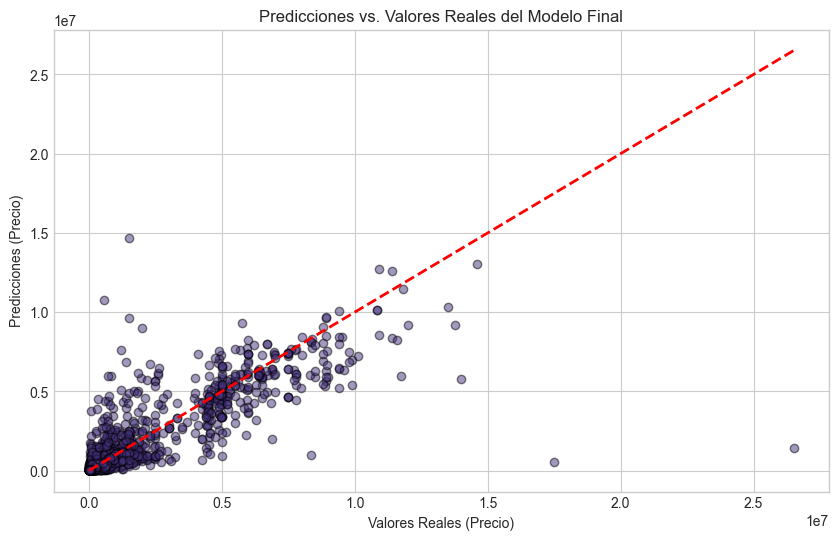

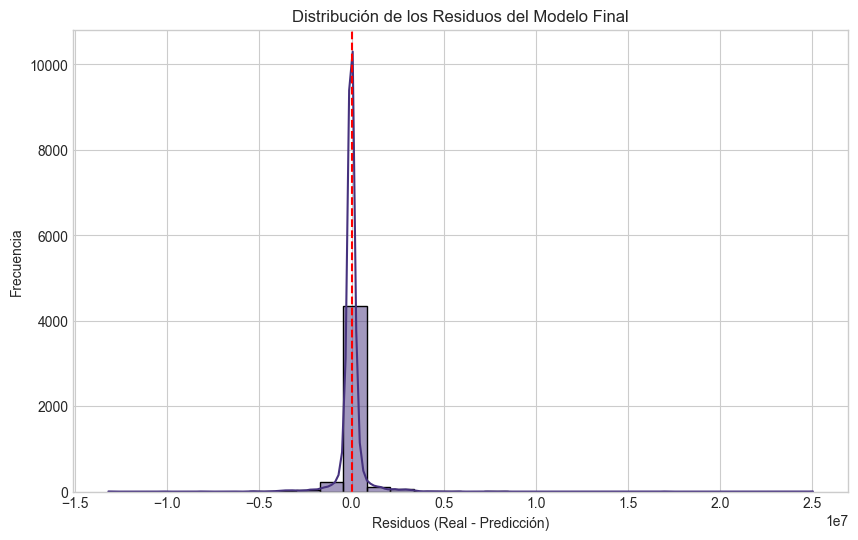

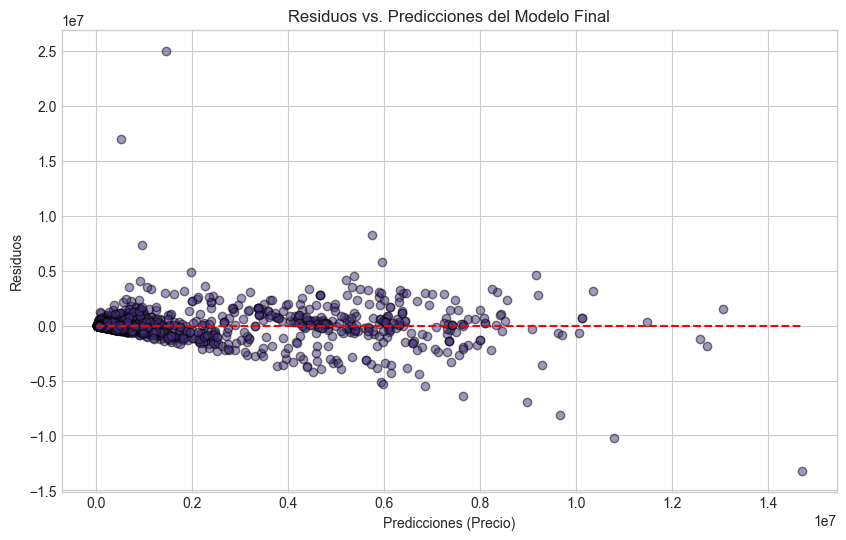

In [12]:
if final_model_pipeline is not None and not X_test.empty:
    print("Evaluando el modelo final en el conjunto de prueba...")
    try:
        y_pred_final = final_model_pipeline.predict(X_test)
        
        mse_final = mean_squared_error(y_test, y_pred_final)
        rmse_final = np.sqrt(mse_final)
        mae_final = mean_absolute_error(y_test, y_pred_final)
        r2_final = r2_score(y_test, y_pred_final)
        
        print("\n--- Métricas del Modelo Final en el Conjunto de Prueba ---")
        print(f"MSE: {mse_final:.2f}")
        print(f"RMSE: {rmse_final:.2f}")
        print(f"MAE: {mae_final:.2f}")
        print(f"R2 Score: {r2_final:.4f}")
        
        # Visualización de Predicciones vs. Valores Reales
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_final, alpha=0.5, edgecolors='k')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel("Valores Reales (Precio)")
        plt.ylabel("Predicciones (Precio)")
        plt.title("Predicciones vs. Valores Reales del Modelo Final")
        # Escala logarítmica puede ser útil si los precios tienen un rango muy amplio
        # plt.xscale('log')
        # plt.yscale('log')
        plt.grid(True)
        plt.show()
        
        # Análisis de Residuos
        residuos = y_test - y_pred_final
        plt.figure(figsize=(10, 6))
        sns.histplot(residuos, kde=True, bins=30)
        plt.xlabel("Residuos (Real - Predicción)")
        plt.ylabel("Frecuencia")
        plt.title("Distribución de los Residuos del Modelo Final")
        plt.axvline(0, color='r', linestyle='--')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_final, residuos, alpha=0.5, edgecolors='k')
        plt.hlines(0, xmin=y_pred_final.min(), xmax=y_pred_final.max(), colors='r', linestyles='--')
        plt.xlabel("Predicciones (Precio)")
        plt.ylabel("Residuos")
        plt.title("Residuos vs. Predicciones del Modelo Final")
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"Error durante la evaluación detallada del modelo final: {e}")
        
else:
    print("No hay un modelo final entrenado o X_test está vacío. No se puede realizar la evaluación detallada.")

## 10. Análisis de Importancia de Características del Modelo Final
Para entender qué factores influyen más en las predicciones de precios, analizaremos la importancia de las características del modelo final. Si el modelo es basado en árboles (como Random Forest o Gradient Boosting), podemos usar el atributo `feature_importances_`. Para un análisis más profundo y aplicable a más tipos de modelos, se podrían usar los valores SHAP (SHapley Additive exPlanations), aunque su implementación puede ser más compleja.


--- Importancia de Características (del modelo) ---


,feature,importance
0,num__superficie,0.74
2,num__baños,0.15
1,num__habitaciones,0.07
5,cat__tipo_propiedad_chalet,0.01
16,cat__provincia_Málaga,0.01
12,cat__provincia_Desconocida,0.00
4,cat__tipo_propiedad_casa_rural,0.00
17,cat__provincia_Sevilla,0.00
14,cat__provincia_Huelva,0.00
10,cat__provincia_Cádiz,0.00


C:\Users\danie\AppData\Local\Temp\ipykernel_50816\3889865831.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


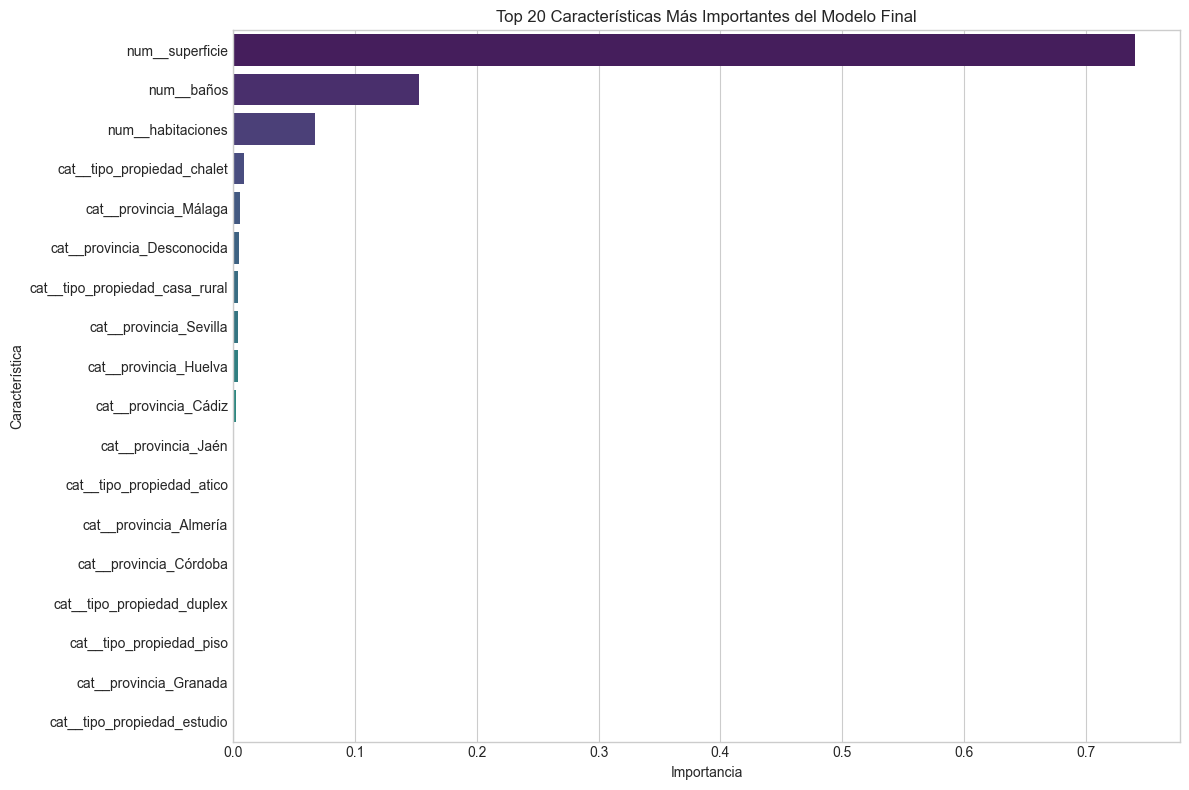

In [13]:
if final_model_pipeline is not None:
    try:
        # Acceder al preprocesador y al modelo dentro del pipeline
        preprocessor_fitted = final_model_pipeline.named_steps['preprocessor']
        regressor_fitted = final_model_pipeline.named_steps['regressor']
        
        # Obtener los nombres de las características después del preprocesamiento (OneHotEncoding, etc.)
        try:
            feature_names_transformed = preprocessor_fitted.get_feature_names_out()
        except AttributeError: # Para versiones antiguas de scikit-learn
            # Intentar construir los nombres manualmente (puede ser complejo y propenso a errores)
            # Esta es una aproximación y puede necesitar ajustes
            feature_names_transformed = []
            for name, trans, cols in preprocessor_fitted.transformers_:
                if trans == 'drop' or trans == 'passthrough':
                    continue
                if hasattr(trans, 'get_feature_names_out'):
                    feature_names_transformed.extend(trans.get_feature_names_out(cols))
                elif hasattr(trans, 'get_feature_names'): # Para OneHotEncoder más antiguo
                     feature_names_transformed.extend(trans.get_feature_names(cols))
                else: # Para escaladores u otros
                    feature_names_transformed.extend(cols)
            print("Advertencia: get_feature_names_out no disponible, nombres de características inferidos.")


        if hasattr(regressor_fitted, 'feature_importances_'):
            importances = regressor_fitted.feature_importances_
            
            feature_importance_df = pd.DataFrame({
                'feature': feature_names_transformed,
                'importance': importances
            }).sort_values(by='importance', ascending=False)
            
            print("\n--- Importancia de Características (del modelo) ---")
            display(feature_importance_df.head(20)) # Mostrar las 20 más importantes
            
            plt.figure(figsize=(12, 8))
            sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
            plt.title('Top 20 Características Más Importantes del Modelo Final')
            plt.xlabel('Importancia')
            plt.ylabel('Característica')
            plt.tight_layout()
            plt.show()

        elif hasattr(regressor_fitted, 'coef_') and isinstance(regressor_fitted, (LinearRegression, Lasso, Ridge)):
            # Para modelos lineales, los coeficientes indican importancia (magnitud) y dirección
            coefficients = regressor_fitted.coef_
            feature_coeffs_df = pd.DataFrame({
                'feature': feature_names_transformed,
                'coefficient': coefficients
            }).sort_values(by='coefficient', key=abs, ascending=False)

            print("\n--- Coeficientes de Características (Modelos Lineales) ---")
            display(feature_coeffs_df.head(20))

            plt.figure(figsize=(12, 8))
            sns.barplot(x='coefficient', y='feature', data=feature_coeffs_df.head(20), palette='coolwarm')
            plt.title('Top 20 Coeficientes de Características del Modelo Lineal Final')
            plt.xlabel('Coeficiente')
            plt.ylabel('Característica')
            plt.tight_layout()
            plt.show()
            
        else:
            print(f"El modelo {type(regressor_fitted).__name__} no tiene un atributo 'feature_importances_' o 'coef_' estándar.")
            print("Considere usar SHAP para un análisis de importancia más general.")
            # Ejemplo de cómo se podría iniciar SHAP (requiere instalación y datos preprocesados):
            # import shap
            # X_train_processed = preprocessor_fitted.transform(X_train)
            # X_test_processed = preprocessor_fitted.transform(X_test)
            # if isinstance(regressor_fitted, (RandomForestRegressor, GradientBoostingRegressor, DecisionTreeRegressor)):
            #     explainer = shap.TreeExplainer(regressor_fitted, X_train_processed) # Pasar datos de entrenamiento para algunos explainers
            #     shap_values = explainer.shap_values(X_test_processed) # Calcular para el conjunto de prueba
            #     shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names_transformed)
            # else: # Para otros modelos, puede ser KernelExplainer
            #     # KernelExplainer puede ser lento, usar una muestra de X_train_processed para el background
            #     background_sample = shap.sample(X_train_processed, 100) 
            #     explainer = shap.KernelExplainer(regressor_fitted.predict, background_sample)
            #     shap_values = explainer.shap_values(X_test_processed)
            #     shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names_transformed)

    except Exception as e:
        print(f"Error durante el análisis de importancia de características: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No hay un modelo final disponible para analizar la importancia de características.")

## 11. Guardado del Modelo Final para Despliegue
Finalmente, guardaremos el pipeline completo del modelo final entrenado (que incluye los preprocesadores y el modelo de regresión con sus hiperparámetros óptimos). Esto permitirá cargar el modelo en el futuro para realizar predicciones en nuevos datos, por ejemplo, en una API o aplicación web.

In [14]:
if final_model_pipeline is not None:
    # Definir la ruta y el nombre del archivo para guardar el modelo
    # Guardarlo en una carpeta 'models' dentro del directorio base del proyecto
    try:
        models_dir = os.path.join(base_dir, 'models') # base_dir definido en la carga de datos
        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
            print(f"Directorio '{models_dir}' creado.")
            
        model_filename = 'final_housing_price_model_andalucia.joblib'
        model_path_to_save = os.path.join(models_dir, model_filename)
        
        joblib.dump(final_model_pipeline, model_path_to_save)
        print(f"Modelo final guardado exitosamente en: {model_path_to_save}")
        
        # Ejemplo de cómo cargarlo después:
        # loaded_model_pipeline = joblib.load(model_path_to_save)
        # print("\nModelo cargado exitosamente (ejemplo).")
        # Para usarlo:
        # new_data = pd.DataFrame(...) # Nuevos datos con el mismo formato que X_train original
        # predictions = loaded_model_pipeline.predict(new_data)
        
    except NameError:
        print("Error: 'base_dir' no está definido. No se puede determinar la ruta para guardar el modelo.")
        print("Asegúrate de que la celda de carga de datos se ejecutó correctamente.")
    except Exception as e:
        print(f"Error al guardar el modelo: {e}")
else:
    print("No hay un modelo final entrenado para guardar.")

Modelo final guardado exitosamente en: c:\Users\danie\Desktop\Universidad\TFG---Predictor-Precios-Vivienda-Andalucia\models\final_housing_price_model_andalucia.joblib


## Conclusiones y Próximos Pasos

En este cuaderno, hemos desarrollado un pipeline completo para predecir los precios de las viviendas en Andalucía.
1.  Cargamos y exploramos inicialmente los datos.
2.  Realizamos ingeniería de características para extraer la 'provincia'.
3.  Preprocesamos los datos numéricos y categóricos.
4.  (Opcional) Implementamos clustering K-Means para segmentación.
5.  Dividimos los datos en conjuntos de entrenamiento y prueba.
6.  Entrenamos y evaluamos varios modelos de regresión.
7.  Optimizamos los hiperparámetros del modelo más prometedor.
8.  Validamos el modelo usando validación cruzada.
9.  Evaluamos el rendimiento del modelo final en el conjunto de prueba.
10. Analizamos la importancia de las características.
11. Guardamos el modelo final para su despliegue.

**Próximos Pasos Potenciales:**
*   **Mejorar la ingeniería de características:** Explorar transformaciones más complejas, interacciones entre características, o el uso de datos geoespaciales de forma más directa (e.g., distancia a puntos de interés).
*   **Probar modelos más avanzados:** Considerar XGBoost, LightGBM, CatBoost, o redes neuronales más profundas si el rendimiento actual no es suficiente.
*   **Análisis de errores más profundo:** Investigar los casos donde el modelo comete errores significativos para entender sus limitaciones.
*   **Despliegue del modelo:** Crear una API (e.g., con Flask o FastAPI) para servir predicciones.
*   **Monitorización del modelo:** Una vez desplegado, monitorizar su rendimiento en datos nuevos y reentrenarlo periódicamente.